In [2]:
import torch
from torch import nn

import os
import sys

%matplotlib inline
import matplotlib.pyplot as plt

import torchsde

def plot(ts, samples, xlabel, ylabel, title=''):
    ts = ts.cpu()
    samples = samples.squeeze().t().cpu()
    plt.figure()
    for i, sample in enumerate(samples):
        plt.plot(ts, sample, marker='x', label=f'sample {i}')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 1. Solving a simple SDE

In [4]:
class SDE(nn.Module):
    def __init__(self):
        super().__init__()
        self.theta = nn.Parameter(torch.tensor(0.1), requires_grad=True)
        self.noise_type = "diagonal" # specify the nosie type
        self.sde_type = "ito" # specify that the 
        
    def f(self, t, y):
        return torch.sin(t)+self.theta*y # specify the drift funciton
    
    def g(self, t, y):
        return 0.3 * torch.sigmoid(torch.cos(t)*torch.exp(-y)) # specify the diffusion function

The function f and g are arbitrarily chosen for demonstration purposes.

The attributes noise_type and sde_type must be included to inform the solver about how to interpret the SDE, and determine which numerical methods are available.

We use diagonal here, meaning the output of g should be a vector with the same shape as input y, and it is an element-wise function. Note that for any other noise type, we expect the output of g to be a matrix, and a batch matrix-vector product will be performed with the Brownian motion

The codebase supports both Ito SDEs based on Ito integrals and Stratonovich SDEs based on Stratonovich integral.

Now we instantiate an object of the SDE class and call the function sdeint on it

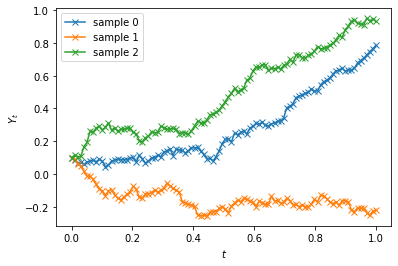

In [5]:
batch_size, state_size, t_size = 3, 1, 100

sde = SDE()
ts = torch.linspace(0, 1, t_size)
y0 = torch.full(size=(batch_size, state_size), fill_value=0.1)
with torch.no_grad():
    ys = torchsde.sdeint(sde, y0, ts, method='euler') # (t_size, batch_size, state_size) = (100,3,1)
plot(ts, ys, xlabel='$t$', ylabel='$Y_t$')

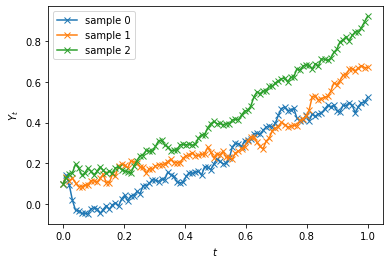

In [6]:
sde.sde_type = "stratonovich"

with torch.no_grad():
    ys = torchsde.sdeint(sde, y0, ts, method='midpoint')
    
plot(ts, ys, xlabel='$t$', ylabel='$Y_t$')

For Stratonovich SDEs, the methods midpoint, euler_heun, heun, milstein, and log_ode are supported

The drift and diffusion functions don't necessarily have to be called f and g. They can be methods with any name, as long as we provide these names to the solver when they differ from the default. The following is an example where h is used as the drift.

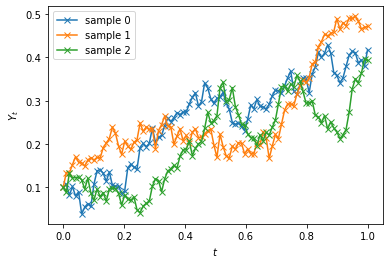

In [7]:
class SDENewName(nn.Module):
    def __init__(self):
        super().__init__()
        self.theta = nn.Parameter(torch.tensor(0.1), requires_grad=True)
        self.noise_type = "diagonal"
        self.sde_type = "ito"
        
    def h(self, t, y):
        return torch.sin(t)+self.theta*y
    
    def g(self, t, y):
        return 0.3 * torch.sigmoid(torch.cos(t)*torch.exp(-y))
    
sde_new_name = SDENewName()

with torch.no_grad():
    ys = torchsde.sdeint(sde_new_name, y0, ts, method='euler', names={'drift':'h'}) # (t_size, batch_size, state_size) = (100,3,1)
plot(ts, ys, xlabel='$t$', ylabel='$Y_t$')

## 2. Explicit control over randomness from the Brownian motion
To gain control over the randomness, we draw Brownian motion samples by instantiating objects of classes BrownianInterval.

In [9]:
ts = torch.linspace(0,1,10)
print(ts)
ts[:-1]

tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])


tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889])

torch.Size([99, 3, 1])
torch.Size([100, 3, 1])


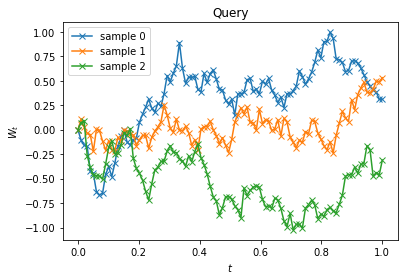

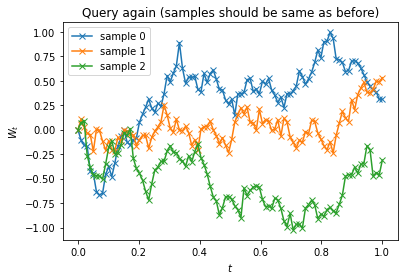

In [11]:
ts = torch.linspace(0, 1, t_size)
bm = torchsde.BrownianInterval(t0=0.0, t1=1.0, size=(batch_size, state_size))

bm_increments = torch.stack([bm(t0, t1) for t0, t1 in zip(ts[:-1], ts[1:])], dim=0)
print(bm_increments.shape) # [99,3,1]
bm_queries = torch.cat((torch.zeros(1, batch_size, state_size), torch.cumsum(bm_increments, dim=0)))
print(bm_queries.shape) # [100, 3, 1]
plot(ts, bm_queries, xlabel='$t$', ylabel='$W_t$', title='Query')

bm_increments2 = torch.stack([bm(t0, t1) for t0, t1 in zip(ts[:-1], ts[1:])], dim=0)
bm_queries2 = torch.cat((torch.zeros(1, batch_size, state_size), torch.cumsum(bm_increments2, dim=0)))
plot(ts, bm_queries2, xlabel='$t$', ylabel='$W_t$', 
     title='Query again (samples should be same as before)')

assert torch.allclose(bm_queries, bm_queries2)

In [30]:
if torch.cuda.is_available():
    bm = torchsde.BrownianInterval(t0=0.0, t1=1.0, size=(batch_size, state_size), device=device)
    print(bm(0.0, 0.5))

tensor([[1.4443],
        [0.6893],
        [0.7203]], device='cuda:0')


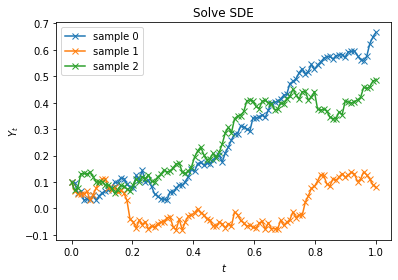

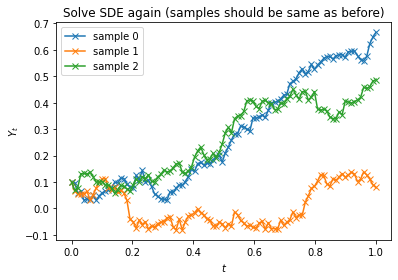

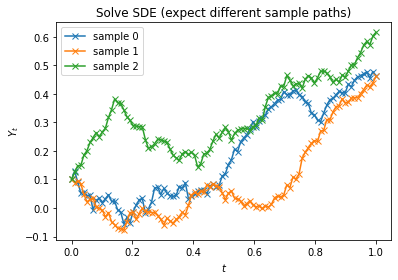

In [31]:
sde = SDE()
ts = torch.linspace(0, 1, t_size)
y0 = torch.zeros((batch_size, 1)).fill_(0.1)  # (batch_size, state_size).
bm = torchsde.BrownianInterval(t0=0.0, t1=1.0, size=(batch_size, state_size))

with torch.no_grad():
    ys = torchsde.sdeint(sde, y0, ts, method='milstein', bm=bm)
plot(ts, ys, xlabel='$t$', ylabel='$Y_t$', title='Solve SDE')

with torch.no_grad():
    ys = torchsde.sdeint(sde, y0, ts, method='milstein', bm=bm)
plot(ts, ys, xlabel='$t$', ylabel='$Y_t$', 
     title='Solve SDE again (samples should be same as before)')

# Use a new BM sample, we expect different sample paths.
bm = torchsde.BrownianInterval(t0=0.0, t1=1.0, size=(batch_size, state_size))
with torch.no_grad():
    ys = torchsde.sdeint(sde, y0, ts, method='milstein', bm=bm)
plot(ts, ys, xlabel='$t$', ylabel='$Y_t$', 
     title='Solve SDE (expect different sample paths)')

## 3. Noise type of SDEs affects which solvers can be used and what strong orders can be attained

The supported noise types of this codebase are "diagonal", "additive", "scalar", and "general". The following is a simple summary of each type:

"diagonal": The diffusion function is an elementwise function, whose output has the same size as that of the state (both are of size (batch_size, state_size)). There are state_size independent Brownian motions, each responsible for the noise of only a single state dimension.

"additive": The diffusion function is constant w.r.t. the state (but not necessarily time). The output of the diffusion function is of size (batch_size, state_size, brownian_size), and the system has brownian_size independent Brownian motions. The integral involving the Brownian motion can be loosely interpreted as integrating a sequence of matrix-vector products.

"scalar": The diffusion function has output shape (batch_size, state_size, 1), and a single Brownian motion is shared across all state dimensions.

"general": The diffusion function has output shape (batch_size, state_size, brownian_size), and the system has brownian_size independent Brownian motions.
It is tempting to use the noise type configuration "general" for all problems. However, since there's little known structure for these SDEs, solvers with high strong-order cannot be constructed.

Lastly, for modeling problems, our limited experience have found "diagonal" to be a good setting, where flexibility of models and tractability of numerical integration is rather well-balanced.

## 4. Computing gradient

In [36]:
ys = torchsde.sdeint(sde, y0, ts, method='euler', bm=bm)
y_final = ys[-1]

target = torch.randn_like(y_final)
loss = ((target - y_final) ** 2).sum(dim=1).mean(dim=0)
loss.backward()
print(sde.theta.grad)

tensor(0.5907)


In [37]:
ys = torchsde.sdeint(sde, y0, ts, method='euler', bm=bm)
y_final = ys[-1]
target = torch.randn_like(y_final)
loss = ((target - y_final) ** 2).sum(dim=1).mean(dim=0)
grad, = torch.autograd.grad(loss, sde.theta)
print(grad)

tensor(0.1690)


In [38]:
ys = torchsde.sdeint_adjoint(sde, y0, ts, method='euler', bm=bm)
y_final = ys[-1]
target = torch.randn_like(y_final)
loss = ((target - y_final) ** 2).sum(dim=1).mean(dim=0)
loss.backward()
print(sde.theta.grad)

tensor(0.9093)
